# Asset Model Loader

A notebook to demonstrate an interface with some of the features of the Asset Model Loader class

Authors: gavin.treseder@essentialenergy.com.au; illyse.schram@essentialenergy.com.au

In [1]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import copy
import pprint
pp = pprint.PrettyPrinter(indent=4)

import pof.demo as demo
from pof.loader.asset_model_loader import AssetModelLoader

# Get the file location

In [13]:
filename = os.path.dirname(os.getcwd()) + r"\data\inputs\Asset Model - Pole - Timber.xlsx"

## Load the data

In [14]:
aml = AssetModelLoader()
data = aml.load(filename)

In [15]:
from pof.component import Component
from pof.failure_mode import FailureMode
from pof.task import Inspection, Task

fm = FailureMode.load(demo.failure_mode_data['slow_aging'])
fm2 = FailureMode.load(data['pole']['fm']['termites'])

insp = Inspection.load(demo.inspection_data['instant'])
insp2 = Inspection.load(data['pole']['fm']['termites']['tasks']['inspection'])

comp = Component.load(demo.component_data)
comp2 = Component.load(data['pole'])

KeyError: 'inspection'

In [29]:
comp = Component.load(data['pole'])

In [30]:
for fm in comp.fm.values():
    fm.active = False
comp.fm['termites'].active = True

In [33]:
comp.mc_timeline(200)
comp.expected_risk_cost_df()
comp.plot_ms()


100%|██████████| 10/10 [00:00<00:00, 18.94it/s]


In [5]:
pp.pprint(data['pole']['fm']['termites'])

{   'conditions': {   'external_diameter': {   'failed': 0.0,
                                               'name': 'external_diameter',
                                               'perfect': 250.0,
                                               'pf_curve': 'linear',
                                               'pf_interval': 8.0,
                                               'pf_std': 0.0},
                      'wall_thickness': {   'failed': 0.0,
                                            'name': 'wall_thickness',
                                            'perfect': 125.0,
                                            'pf_curve': 'linear',
                                            'pf_interval': 8.0,
                                            'pf_std': 0.0}},
    'name': 'termites',
    'tasks': {   'CAT1/2 replacement': {   'Level of Failure': 'component',
                                           'activity': 'ConditionTask',
                                           '

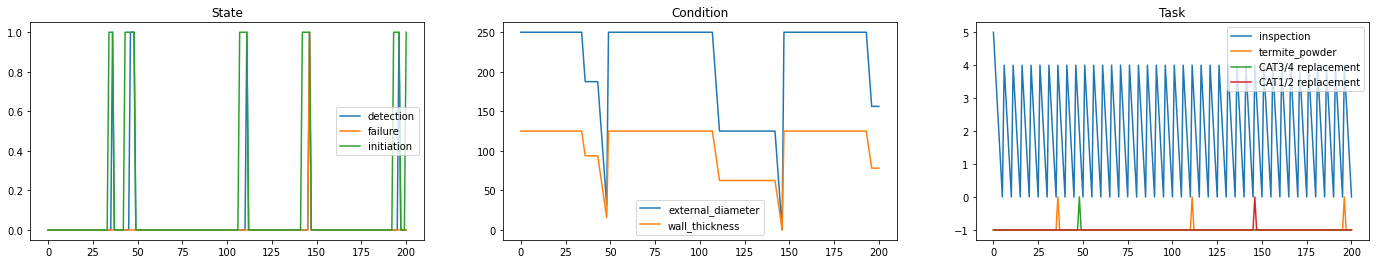

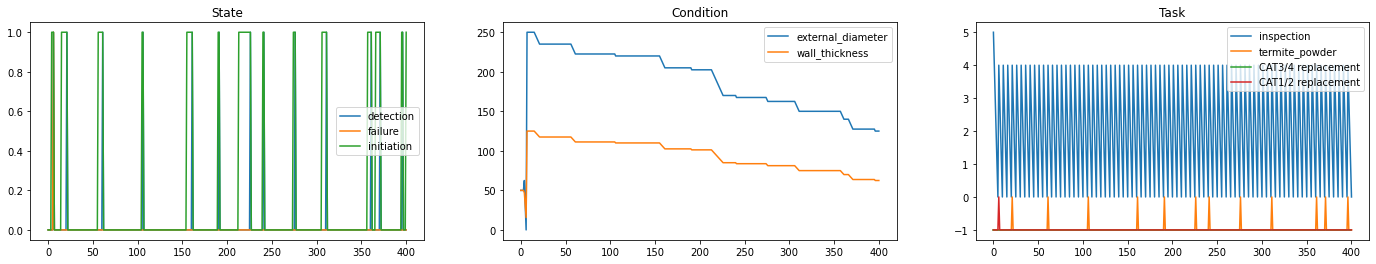

In [6]:
fm2 = FailureMode.load(data['pole']['fm']['termites'])
fm2.sim_timeline(200)
fm2.plot_timeline()
for cond in fm2.conditions.values():
    cond.pf_interval = 100
    cond.set_condition(50)


fm2.sim_timeline(400)
fm2.plot_timeline()

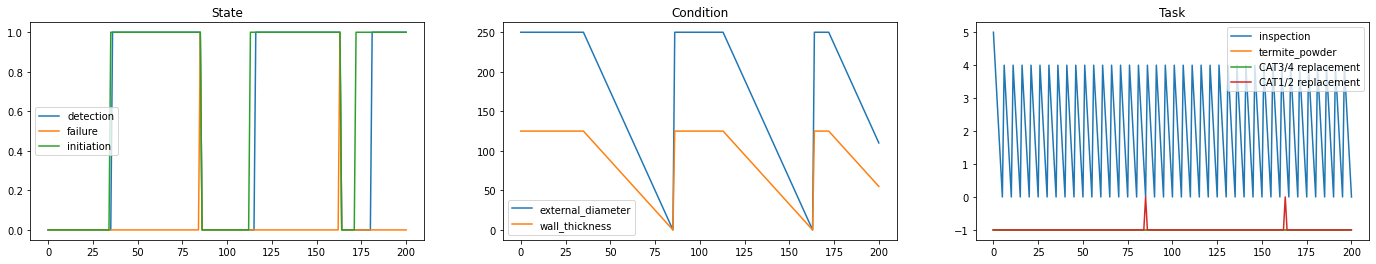

In [10]:
fm2.sim_timeline(200)
fm2.plot_timeline()

In [16]:
fm2.tasks['termite_powder'].__dict__

{'name': 'termite_powder',
 'activity': 'ConditionTask',
 'trigger': 'condition',
 'active': True,
 '_package': NotImplemented,
 '_impacts_parent': NotImplemented,
 '_impacts_children': False,
 'cost': 100.0,
 'labour': NotImplemented,
 'spares': NotImplemented,
 'equipment': NotImplemented,
 'consequence': <pof.consequence.Consequence at 0x21ac568c340>,
 'p_effective': 0.9,
 'triggers': {'state': {'initiation': True,
   'detection': True,
   'failure': False},
  'condition': {'wall_thickness': {'lower': 50.0, 'upper': 'max'},
   'external_diameter': {'lower': 50.0, 'upper': 'max'}},
  'time': {}},
 'impacts': {'state': {'initiation': False,
   'detection': False,
   'failure': False},
  'condition': {'all': {'target': 0.0,
    'method': 'reduction_factor',
    'axis': 'condition'}},
  'time': {}},
 'component_reset': False,
 'state': NotImplemented,
 't_completion': [],
 'cost_completion': [],
 '_timeline': NotImplemented,
 'task_type': 'immediate'}

In [ ]:
pp.pprint(data['pole']['fm']['termites'])

# Explore the data manually

In [4]:
df = pd.read_excel(filename, sheet_name='Model Input', header=[0,1,2])
df.head()

Unnamed: 0_level_0 asset_model                            indicator_model  \
  Unnamed: 0_level_1      system sub_system component             indicator   
                  id        name       name      name                  name   
0                NaN         NaN        NaN      pole        wall_thickness   
1                NaN         NaN        NaN       NaN     external_diameter   
2                NaN         NaN        NaN       NaN  simple_safety_factor   
3                NaN         NaN        NaN       NaN  actual_safety_factor   
4                NaN         NaN        NaN       NaN      lightning_damage   

                           failure_model               ...      trigger_model  \
                            failure_mode distribution  ...          condition   
       dist perfect failed          name        alpha  ...               name   
0    linear   125.0    0.0      termites         50.0  ...     wall_thickness   
1    linear   250.0    0.0           NaN          NaN  ...  external_diameter   
2  ssf_calc     4.0    1.0           NaN          NaN  ...                NaN   
3  dsf_calc     6.0    1.0           NaN          NaN  ...     wall_thickness   
4      step     1.0    0.0           NaN          NaN  ...  external_diameter   

              impact_model                                     \
                     state                   condition          
  lower upper   initiation detection failure      name target   
0   0.0   -20          NaN       1.0     NaN       NaN    NaN   
1   0.0   -10          NaN       NaN     NaN       NaN    NaN   
2   NaN   NaN          NaN       NaN     NaN       NaN    NaN   
3  50.0   max          0.0       0.0     0.0       all    0.0   
4  50.0   max          NaN       NaN     NaN       NaN    NaN   

                                
                                
             method       axis  
0               NaN        NaN  
1               NaN        NaN  
2               NaN        NaN  
3  reduction_factor  condition  
4               NaN        NaN  

[5 rows x 50 columns]

In [5]:
df = df.dropna(axis=1, how='all')
df.head()

asset_model       indicator_model                          failure_model  \
    component             indicator                           failure_mode   
         name                  name      dist perfect failed          name   
0        pole        wall_thickness    linear   125.0    0.0      termites   
1         NaN     external_diameter    linear   250.0    0.0           NaN   
2         NaN  simple_safety_factor  ssf_calc     4.0    1.0           NaN   
3         NaN  actual_safety_factor  dsf_calc     6.0    1.0           NaN   
4         NaN      lightning_damage      step     1.0    0.0           NaN   

                                    ...      trigger_model              \
  distribution                      ...          condition               
         alpha beta gamma pf_curve  ...               name lower upper   
0         50.0  1.5  10.0   linear  ...     wall_thickness   0.0   -20   
1          NaN  NaN   NaN      NaN  ...  external_diameter   0.0   -10   
2          NaN  NaN   NaN      NaN  ...                NaN   NaN   NaN   
3          NaN  NaN   NaN      NaN  ...     wall_thickness  50.0   max   
4          NaN  NaN   NaN      NaN  ...  external_diameter  50.0   max   

  impact_model                                                                  
         state                   condition                                      
    initiation detection failure      name target            method       axis  
0          NaN       1.0     NaN       NaN    NaN               NaN        NaN  
1          NaN       NaN     NaN       NaN    NaN               NaN        NaN  
2          NaN       NaN     NaN       NaN    NaN               NaN        NaN  
3          0.0       0.0     0.0       all    0.0  reduction_factor  condition  
4          NaN       NaN     NaN       NaN    NaN               NaN        NaN  

[5 rows x 42 columns]

In [6]:
# Create keys
keys = dict(
    asset_model = ('asset_model', 'component', 'name'),
    #('indicator_model', 'indicator','name'),
    failure_model = ('failure_model', 'failure_mode', 'name'),
    task_model = ('task_model', 'task', 'name'),
    #('trigger_model', 'condition', 'name'), #TODO revist this one
    #('impact_model', 'condition', 'name'),
)

In [7]:
def validate_keys(keys, df):
    missing_keys = [key for key in keys if key not in df.columns]

    if bool(missing_keys):
        print("Missing Keys: %s" %(missing_keys))
        return False
    else:
        return True

validate_keys(keys, df)

True

In [8]:
def rename_duplicates(df, primary_key, foreign_key):
    """
    Warning: changes values of
    """
    if isinstance(primary_key, list):
        key_cols = primary_key + foreign_key
    mask_key = df[key_cols].notnull().any(axis=1)
    mask_dup = df.loc[mask_key, key_cols].ffill().duplicated(keep=False)

    mask = mask_key & mask_dup
    df.loc[mask, keys['task_model']] += '.' + df[key_cols].loc[mask].ffill().groupby(key_cols).cumcount().add(1).astype(str)

    


In [9]:
# Check Failure Modes aren't duplicated
key_cols = [keys['asset_model'], keys['failure_model']]
mask_key = df[key_cols].notnull().any(axis=1)
mask_dup = df.loc[mask_key, key_cols].ffill().duplicated(keep=False)

mask = mask_key & mask_dup
df.loc[mask, keys['failure_model']] += '.' + df[key_cols].loc[mask].ffill().groupby(key_cols).cumcount().add(1).astype(str)

# Check Tasks aren't duplicated
key_cols = [keys['asset_model'], keys['failure_model'], keys['task_model']]
mask_key = df[key_cols].notnull().any(axis=1)
mask_dup = df.loc[mask_key, key_cols].ffill().duplicated(keep=False)

mask = mask_key & mask_dup
df.loc[mask, keys['task_model']] += '.' + df[key_cols].loc[mask].ffill().groupby(key_cols).cumcount().add(1).astype(str)

In [10]:
def get_failure_mode_data(df_comp):

    fms_data = dict() #TODO
    fm_key = ('failure_model', 'failure_mode', 'name')
    failure_modes = df_comp[fm_key].unique()
    df_fms = df_comp[['failure_model', 'condition_model', 'task_model', 'trigger_model', 'impact_model']].set_index(fm_key)

    for fm in failure_modes:

        df_fm = df_fms.loc[[fm]]

        # Get the Task information
        tasks_data = get_task_data(df_fm)
        
        # Get the Distribution information
        dist_data = get_dist_data(df_fm)

        # Get the Condition information
        condition_data = get_condition_data(df_fm)

        fm_data = dict(
            name = fm,
            conditions = condition_data,
            tasks = tasks_data,
            untreated = dist_data,
        )
        fms_data.update({
            fm : fm_data,
        })

    return fms_data

In [11]:
def get_condition_data(df_fm):
    #TODO update for new arrangement
    df_cond = df_fm['condition_model']
    conditions = df_cond['condition']['name'].dropna().to_numpy()
    cond_data = {cond : None for cond in conditions}
    return cond_data

In [12]:
def get_dist_data(df_fm):

    df_dist = df_fm['failure_model'].dropna()
    df_dist.columns = df_dist.columns.droplevel()

    try:

        dist_data = df_dist.iloc[0].dropna().to_dict()
    except IndexError:
        dist_data = df_dist.dropna().to_dict()

    return dist_data

In [13]:
def get_task_data(df_fm):
    """Takes a dataframe for a failure mode and returns a dict of task data
    """
    tasks_data = dict()
    task_key = ('task_model', 'task', 'name')
    tasks = df_fm[task_key].unique()
    df_tasks = df_fm[['task_model', 'trigger_model', 'impact_model']].set_index(task_key)

    for task in tasks:

        df_task = df_tasks.loc[[task]].dropna(axis=0, how='all')

        # Trigger information
        try:
            state = df_task['trigger_model']['state'].iloc[0].dropna().to_dict(),
        except:
            state = df_task['trigger_model']['state'].dropna().to_dict(),

        trigger_data = dict(
            state = state,
            condition = df_task['trigger_model']['condition'].dropna().set_index('name').to_dict('index')
        )

        # Impact information
        try:
            state = df_task['impact_model']['state'].iloc[0].dropna().to_dict(),
        except:
            state = df_task['impact_model']['state'].dropna().to_dict(),
            
        impact_data = dict(
            state = state,
            condition = df_task['impact_model']['condition'].dropna().set_index('name').to_dict('index')
        )

        # Tasks specific information
        df_tsi = df_task[('task_model')].dropna(how='all').dropna(axis=1)
        df_tsi.columns = df_tsi.columns.droplevel()

        task_data = df_tsi.to_dict('index') #TODO currently has too many vars
        try:
            task_data[task].update(dict(
                name=task,
                triggers=trigger_data,
                impacts = impact_data,
            ))
        except:
            task_data = dict(
                task = dict(
                    name=task,
                    triggers=trigger_data,
                    impacts = impact_data,
                )
            )

        tasks_data.update(task_data)

    return tasks_data

In [14]:
def _get_component_data(df):
    comps_data = dict()

    # Get the Component information
    comp_key = ('asset_model', 'component', 'name')
    components = df[comp_key].dropna().unique()

    df_comps = df[['asset_model', 'failure_model', 'condition_model', 'task_model', 'trigger_model', 'impact_model']].set_index(comp_key)

    for comp in components:

        df_comp = df_comps.loc[[comp]]

        # Get the FailureMode information
        fm_data = get_failure_mode_data(df_comp)

        comp_data = dict(
            fm = fm_data,
        )

        comps_data.update({
            comp : comp_data
        })

    return comps_data

In [15]:
comp2 = _get_component_data(df)

# Flat version of what happens in the functions

In [20]:
df = df.dropna(how="all")

In [21]:
comps_data = dict()

# Get the Component information
comp_key = ('asset_model', 'component', 'name')
components = df[comp_key].unique()

df_comps = df[['asset_model', 'failure_model', 'condition_model', 'task_model', 'trigger_model', 'impact_model']].set_index(comp_key)

for comp in ['pole']:

    df_comp = df_comps.loc[[comp]]

    fms_data = dict() #TODO
    fm_key = ('failure_model', 'failure_mode', 'name')
    failure_modes = df_comp[fm_key].unique()
    df_fms = df_comp[['failure_model', 'condition_model', 'task_model', 'trigger_model', 'impact_model']].set_index(fm_key)

    for fm in ['termites']:
        
        df_fm = df_fms.loc[[fm]]
        # Get the Task information
        tasks_data = get_task_data(df_fm)
        
        # Get the Distribution information
        df_dist = df_fm['failure_model'].dropna()
        df_dist.columns = df_dist.columns.droplevel()

        try:

            dist_data = df_dist.iloc[0].dropna().to_dict()
        except IndexError:
            dist_data = df_dist.dropna().to_dict()

        # Get the Condition information
        break

In [22]:
df_comps.loc[['crossarm']]

failure_model                          \
                                  failure_mode distribution              
                                          name        alpha beta gamma   
(asset_model, component, name)                                           
crossarm                        Fix_this_error          NaN  NaN   NaN   

                                                            \
                                                             
                               pf_curve pf_interval pf_std   
(asset_model, component, name)                               
crossarm                            NaN         NaN    NaN   

                                        condition_model          task_model  \
                                              condition                task   
                                                   name pf_curve       name   
(asset_model, component, name)                                                
crossarm                        add_no_condition_method      NaN      strut   

                                ...   trigger_model             impact_model  \
                                ...       condition                    state   
                                ...            name lower upper   initiation   
(asset_model, component, name)  ...                                            
crossarm                        ...  wall_thickness  50.0   max          NaN   

                                                                         \
                                                       condition          
                               detection failure            name target   
(asset_model, component, name)                                            
crossarm                             NaN     NaN  wall_thickness   50.0   

                                               
                                               
                                  method axis  
(asset_model, component, name)                 
crossarm                        addition  NaN  

[1 rows x 37 columns]

In [25]:
df_comps.loc[['crossarm']]


failure_model                          \
                                  failure_mode distribution              
                                          name        alpha beta gamma   
(asset_model, component, name)                                           
crossarm                        Fix_this_error          NaN  NaN   NaN   

                                                            \
                                                             
                               pf_curve pf_interval pf_std   
(asset_model, component, name)                               
crossarm                            NaN         NaN    NaN   

                                        condition_model          task_model  \
                                              condition                task   
                                                   name pf_curve       name   
(asset_model, component, name)                                                
crossarm                        add_no_condition_method      NaN      strut   

                                ...   trigger_model             impact_model  \
                                ...       condition                    state   
                                ...            name lower upper   initiation   
(asset_model, component, name)  ...                                            
crossarm                        ...  wall_thickness  50.0   max          NaN   

                                                                         \
                                                       condition          
                               detection failure            name target   
(asset_model, component, name)                                            
crossarm                             NaN     NaN  wall_thickness   50.0   

                                               
                                               
                                  method axis  
(asset_model, component, name)                 
crossarm                        addition  NaN  

[1 rows x 37 columns]

{}

In [65]:
from dataclasses import dataclass
from typing import Dict

@dataclass
class simple():

    _val : int = 10
    _dict : Dict = None

    @property
    def val(self):
        return self._val

    @val.setter
    def val(self, value):
        self._val = value

    @property
    def dic(self):
        return self._dict

    @dic.setter
    def dic(self, value):
        if self._dict is None:
            self._dict = dict()
        
        if isinstance(value, str):
            print('string')
            self._dict = value

        elif value == 'ten':
            print('class')
            self._dict['hundred'] = 'hundred'

        elif isinstance(value, dict):
            print('dict')
            for k, v in value.items():
                self.dic = v

        else:
            print("Invalid value")


In [66]:
s = simple()

In [67]:
s.dic = {'thirty': 30, 'ten':'ten'}

dict
Invalid value
string


In [68]:
s.val = 15
s.val

15

In [69]:
s.dic = 15
s.dic

Invalid value


'ten'

In [70]:
s.dic = 25
s.dic

Invalid value


'ten'

In [72]:
s.__dict__

{'_val': 15, '_dict': 'ten'}

In [76]:
from pof.config import config

ModuleNotFoundError: No module named 'ConfigParser'